# Nested sampling

In the [MCMC tutorial](./mcmc.html), Bayes theorem was shown, 

$$ p = \frac{P L}{Z}, $$

where where, $p$ is the posterior probability, $P$ is the prior probability, $L$ is the likelihood, and $Z$ is the evidence. 
Normally, in the evaluation of the posterior probability, the evidence is removed as a constant of propertionality. 
This is due to the fact that it is a single value for a given model and dataset pair. 

However, sometimes it is desirable to find the evidence for a model to a given dataset.
In particular, when we want to compare the evidence for a series of models, to determine which best describes the dataset.
In order to achieve this, `uravu` is able to perform [nested sampling](https://doi.org/10.1063/1.1835238) to estimate the Bayesian evidence for a model given a particular dataset. 

This tutorial will show how this is achieved, and show the utility of Bayesian model selection. 

However, as always we must first create some *synthetic* data. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(2)

In [3]:
x = np.linspace(10, 50, 20)
y = .3 * x ** 2 - 1.4 * x + .2
y += y * np.random.randn(20) * 0.05
dy = 3 * x

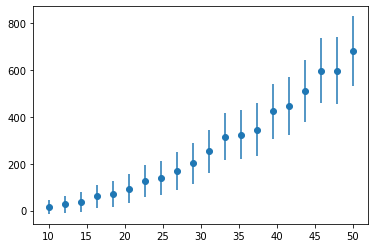

In [4]:
plt.errorbar(x, y, dy, marker='o', ls='')
plt.show()

From looking at the code used to synthesize this data, it is clear that the functional from of the model is a quadratic polynomial. 
However, if this was data collected from some measurement and the physical theory suggests it should be analysed with a polynormial of unknown degree then Bayesian model selection would be the ideal tool to find the best model. 

Let's quickly write a few models to perform the `n` degree polynomial analysis with. 

In [5]:
def one_degree(x, a, b):
    return b * x + a

def two_degree(x, a, b, c):
    return c * x ** 2 + b * x + a

def three_degree(x, a, b, c, d):
    return d * x ** 3 + c * x ** 2 + b * x + a

def four_degree(x, a, b, c, d, e):
    return e * x ** 4 + d * x ** 3 + c * x ** 2 + b * x + a

With these functions defined, we can now build the `Relationship` objects for each of the functions. 

In [6]:
from uravu.relationship import Relationship

In [7]:
one_modeller = Relationship(one_degree, x, y, dy)
one_modeller.max_likelihood()

In [8]:
two_modeller = Relationship(two_degree, x, y, dy)
two_modeller.max_likelihood()

In [9]:
three_modeller = Relationship(three_degree, x, y, dy)
three_modeller.max_likelihood()

In [10]:
four_modeller = Relationship(four_degree, x, y, dy)
four_modeller.max_likelihood()

Having built these, lets see what the maximum likelihood variables are for each. 

In [11]:
print(one_modeller.variables)

[-153.8553571    13.92874371]


In [12]:
print(two_modeller.variables)

[ 1.9562903  -1.70809576  0.30668596]


In [13]:
print(three_modeller.variables)

[ 1.60179282e+01 -3.77517349e+00  3.93402486e-01 -1.06483344e-03]


In [14]:
print(four_modeller.variables)

[ 3.95429295e-01 -5.21693367e-01  1.67738161e-01  5.13574233e-03
 -5.79314475e-05]


We can see that the highest order terms are quite small for the larger degree of polynomial. 
Let's see what effect this has on the evidence. 

Note that `uravu` and `dynesty` calculates the natural log of the evidence, $\ln{Z}$. 

In [15]:
one_modeller.nested_sampling()

4075it [00:21, 186.80it/s, +500 | bound: 7 | nc: 1 | ncall: 22142 | eff(%): 20.662 | loglstar:   -inf < -90.901 <    inf | logz: -98.201 +/-  0.159 | dlogz:  0.001 >  0.509]


In [16]:
two_modeller.nested_sampling()

3183it [00:26, 121.91it/s, +500 | bound: 5 | nc: 1 | ncall: 21949 | eff(%): 16.780 | loglstar:   -inf < -88.205 <    inf | logz: -93.717 +/-  0.133 | dlogz:  0.001 >  0.509]


In [17]:
three_modeller.nested_sampling()

3770it [00:35, 106.43it/s, +500 | bound: 8 | nc: 1 | ncall: 22629 | eff(%): 18.870 | loglstar:   -inf < -88.216 <    inf | logz: -94.947 +/-  0.154 | dlogz:  0.001 >  0.509]


In [18]:
four_modeller.nested_sampling()

3375it [00:36, 92.82it/s, +500 | bound: 6 | nc: 1 | ncall: 22121 | eff(%): 17.517 | loglstar:   -inf < -88.212 <    inf | logz: -94.168 +/-  0.143 | dlogz:  0.001 >  0.509]


Having estimated $\ln{Z}$ for each `Relationship`, lets plot them as a function of the number of variables in the model.

In [19]:
variables = [len(one_modeller.variables), len(two_modeller.variables),
             len(three_modeller.variables), len(four_modeller.variables)]
ln_evidence = [one_modeller.ln_evidence.n, two_modeller.ln_evidence.n,
               three_modeller.ln_evidence.n, four_modeller.ln_evidence.n]
ln_evidence_err = [one_modeller.ln_evidence.s, two_modeller.ln_evidence.s,
                   three_modeller.ln_evidence.s, four_modeller.ln_evidence.s]

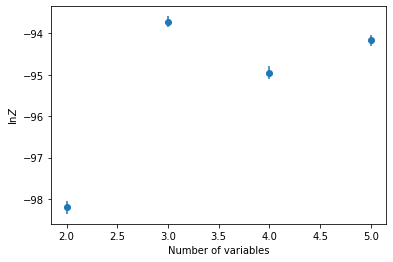

In [20]:
plt.errorbar(variables, ln_evidence, ln_evidence_err, marker='o', ls='')
plt.xlabel('Number of variables')
plt.ylabel(r'$\ln{Z}$')
plt.show()

We can see that the evidence reaches a maxiumum at 3 variables (the `two_degree` model), this indicates that this is the most probable model for analysis of this dataset. 

Finally, we can use some build in functionality of `uravu` to compare different evidence values, in a value known as the [Bayes factor](https://doi.org/10.2307/2291091). 
Let's compare the `one_degree` and `two_degree` models.

In [21]:
from uravu import utils

In [22]:
print(utils.bayes_factor(two_modeller.ln_evidence, one_modeller.ln_evidence))

9.0+/-0.4


The Bayes factor between the two and one degree models, $2\ln{B_{21}}$, has a value of ~9. 
The Table in [Kass and Raftery](https://doi.org/10.2307/2291091) suggests that this shows "Strong" evidence for the model with more variables (the `two_degree` model). 

This means that it is sensible to go ahead and use the `two_degree` model in the further analysis of our data, using MCMC for example. 

In [23]:
two_modeller.mcmc()

100%|██████████| 1000/1000 [01:11<00:00, 13.96it/s]


In [24]:
from uravu import plotting

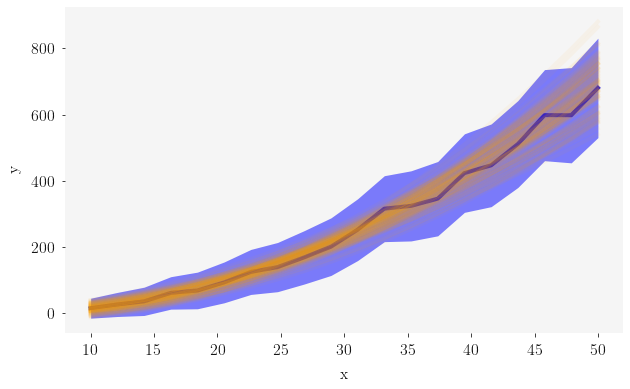

In [25]:
plotting.plot_relationship(two_modeller)
plt.show()